In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np
import warnings as wn
from xhistogram.xarray import histogram as xh
%reload_ext autoreload
%autoreload 2
import esm2m.myfunctions as func

In [2]:
wn.filterwarnings('ignore')
cod = pd.read_csv('species/atlantic_cod.csv', header=0)
bass = pd.read_csv('species/stripped_bass.csv', header=0)
flounder = pd.read_csv('species/summer_flounder.csv', header=0)
seabream = pd.read_csv('species/seabream.csv', header=0)
red_drum = pd.read_csv('species/red_drum.csv', header=0)
n_lampfish = pd.read_csv('species/northern_lampfish.csv', header=0)
blue_lampfish = pd.read_csv('species/blue_lampfish.csv', header=0)
cunner = pd.read_csv('species/cunner.csv', header=0)
eelpout = pd.read_csv('species/eelpout.csv', header=0)

In [3]:
rootdir = '/local/ss23/GFDL_LEs/'
subdir = 'AREA_FILES_ETC'
filename_area = 'WOA2001_grid.nc'
path_area = rootdir+subdir+'/'+filename_area
area = xr.open_dataset(path_area)['AREA'].rename({'latitude':'yt_ocean','longitude':'xt_ocean'})
area = area.assign_coords({'xt_ocean':bass_avg['xt_ocean'],'yt_ocean':bass_avg['yt_ocean']})
oceanmask = np.isfinite(bass_avg['MI'].isel(time=0).squeeze())
area_masked = area.where(oceanmask,np.nan)
ds_total = ~np.isnan(area.where(oceanmask))
total = ds_total.sum(dim='yt_ocean').sum(dim='xt_ocean')

NameError: name 'bass_avg' is not defined

In [ ]:
rootdir = '/local/rodgers/MI_JUL13_2020_RCP85'
filename = 'sfc_MI_ens1*_1x1_1950_2100.nc'
path = rootdir+'/'+filename
bass_all = xr.open_mfdataset(path, engine='netcdf4', concat_dim='ensemble', combine='nested')
bass_avg = bass_all.mean(dim='ensemble')

In [ ]:
flounder_hab = func.species_hab(flounder)
mi_flounder = func.mi_hab(bass_all, 3.5, flounder_hab, area_masked)

Text(0, 0.5, 'Percent of 1990 habitat')

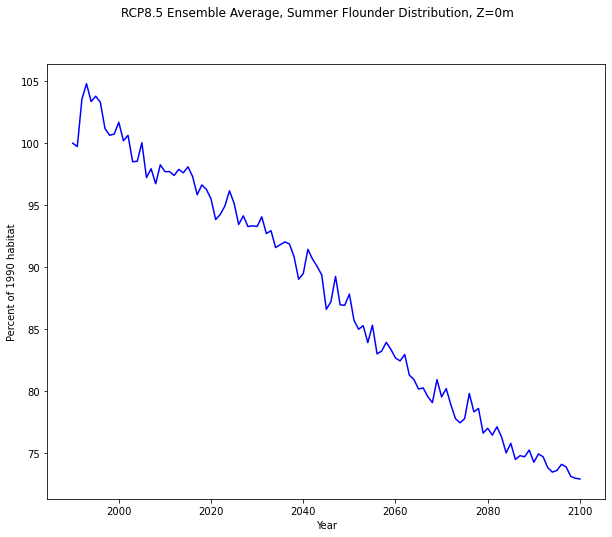

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
wn.filterwarnings('ignore')
fig.suptitle('RCP8.5 Ensemble Average, Summer Flounder Distribution, Z=0m')
ax.plot(np.unique(mi_flounder['year']),mi_flounder,color='blue')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 1990 habitat')

In [11]:
flounder_hab = func.species_dist(flounder)
mi_flounder = func.mi_dist(bass_all, 3.5, flounder_hab, area_masked)

Text(0, 0.5, 'Percent of Distribution')

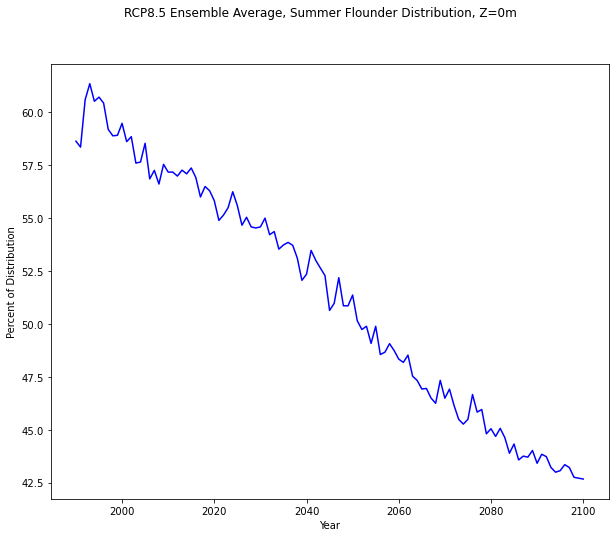

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
wn.filterwarnings('ignore')
fig.suptitle('RCP8.5 Ensemble Average, Summer Flounder Distribution, Z=0m')
ax.plot(np.unique(mi_flounder['year']),mi_flounder,color='blue')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of Distribution')

In [ ]:
def get_species(species):
    ds_cod = species.to_xarray()
    lon_bins = np.arange(-180,181)
    lat_bins = np.arange(-90,91)
    species_dist = xh(ds_cod['decimalLatitude'], ds_cod['decimalLongitude'],bins=[lat_bins, lon_bins])
    ds_hab = species_dist.to_dataset().rename({'histogram_decimalLatitude_decimalLongitude':'MI','decimalLatitude_bin':'yt_ocean','decimalLongitude_bin':'xt_ocean'})
    ds_hab = ~np.isnan(ds_hab.where(ds_hab['MI']>0.5))
    return ds_hab

In [ ]:
def month(ds, mi, ds_hab, area, num):
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = ds_hab.reindex_like(red, method='nearest', tolerance=0.01)
    total_hab = (hab*area).sum(['xt_ocean','yt_ocean'])
    thresh_red = hab*red
    redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(1990,2100))
    byMonth = ~np.isnan(redMonth.where(redMonth['MI']>=num))
    redNum = (byMonth*area).sum(['xt_ocean','yt_ocean'])
    # redDen = (byMonth.sel(year=1990)*area_masked).sum(['xt_ocean','yt_ocean'])
    percent = (redNum['MI']/total_hab['MI'])*100
    return percent

In [4]:
def month_90(ds, mi, ds_hab, area, num):
    red = ~np.isnan(ds.where(ds['MI']>mi))
    hab = ds_hab.reindex_like(red, method='nearest', tolerance=0.01)
    total_hab = (hab*area).sum(['xt_ocean','yt_ocean'])
    thresh_red = hab*red
    redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(2000,2100))
    byMonth = ~np.isnan(redMonth.where(redMonth['MI']>=num))
    redNum = (byMonth*area).sum(['xt_ocean','yt_ocean'])
    # redDen = (byMonth.sel(year=1990)*area_masked).sum(['xt_ocean','yt_ocean'])
    percent = (redNum['MI']/redNum['MI'].sel(year=2000))*100
    return percent

# Summer Flounder

In [19]:
red = ~np.isnan(bass_avg.where(bass_avg['MI']>3.5))
# red = red.sel(time=slice('2100-01-01','2100-12-31'))
hab = hab.reindex_like(red, method='nearest', tolerance=0.01)
thresh_red = hab*red
redMonth = thresh_red.groupby('time.year').sum(dim='time').sel(year=slice(2000,2100))
byMonth = ~np.isnan(redMonth.where(redMonth['MI']>0))
# redNum = (redMonth*area).sum(['xt_ocean','yt_ocean'])

In [22]:
byMonth.sel(year=2000).sum(['xt_ocean','yt_ocean']).load()

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    st_ocean  float64 5.0
    year      int64 2000
Data variables:
    MI        int64 52

In [17]:
hab = get_species(flounder)
flounder_1 = month_90(bass_avg, 3.5, hab, area_masked, 1)
flounder_3 = month_90(bass_avg, 3.5, hab, area_masked, 3)
flounder_6 = month_90(bass_avg, 3.5, hab, area_masked, 6)
flounder_9 = month_90(bass_avg, 3.5, hab, area_masked, 9)
flounder_12 = month_90(bass_avg, 3.5, hab, area_masked, 12)

Text(0, 0.5, 'Percent of 2000 Habitat')

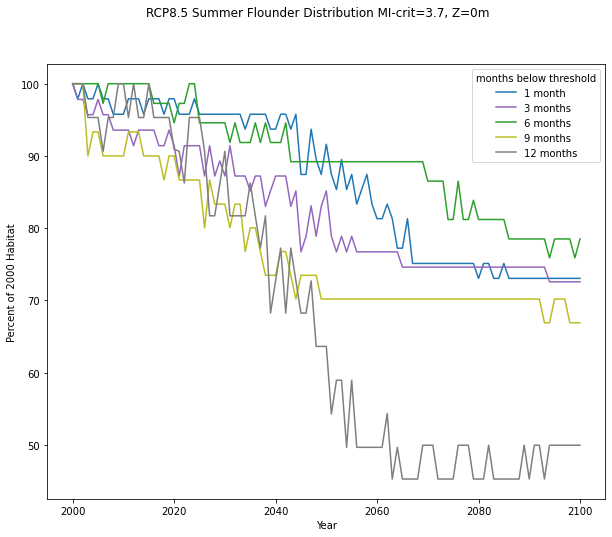

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Summer Flounder Distribution MI-crit=3.7, Z=0m')
ax.plot(np.unique(flounder_1['year']),flounder_1,color='tab:blue',label='1 month')
ax.plot(np.unique(flounder_3['year']),flounder_3,color='tab:purple',label='3 months')
ax.plot(np.unique(flounder_6['year']),flounder_6,color='tab:green',label='6 months')
ax.plot(np.unique(flounder_9['year']),flounder_9,color='tab:olive',label='9 months')
ax.plot(np.unique(flounder_12['year']),flounder_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')

#### E0 = 0.35, A0 = 25.1, MI-crit = 3.5-3.6

In [15]:
hab = get_species(flounder)
flounder_1 = month_90(bass_avg, 3.5, hab, area_masked, 1)
flounder_3 = month_90(bass_avg, 3.5, hab, area_masked, 3)
flounder_6 = month_90(bass_avg, 3.5, hab, area_masked, 6)
flounder_9 = month_90(bass_avg, 3.5, hab, area_masked, 9)
flounder_12 = month_90(bass_avg, 3.5, hab, area_masked, 12)

Text(0, 0.5, 'Percent of 2000 Habitat')

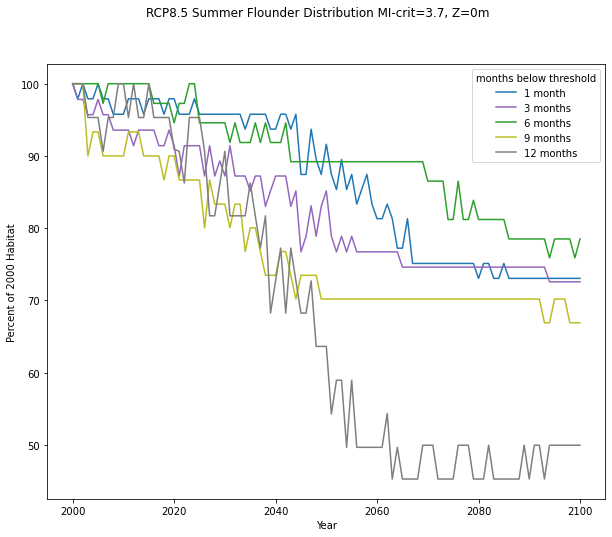

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('RCP8.5 Summer Flounder Distribution MI-crit=3.7, Z=0m')
ax.plot(np.unique(flounder_1['year']),flounder_1,color='tab:blue',label='1 month')
ax.plot(np.unique(flounder_3['year']),flounder_3,color='tab:purple',label='3 months')
ax.plot(np.unique(flounder_6['year']),flounder_6,color='tab:green',label='6 months')
ax.plot(np.unique(flounder_9['year']),flounder_9,color='tab:olive',label='9 months')
ax.plot(np.unique(flounder_12['year']),flounder_12,color='tab:gray',label='12 months')
ax.legend(title='months below threshold')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')

In [19]:
flounder_6.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      ,  97.27375 , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      ,  97.27375 ,  97.27375 ,  97.27375 ,  97.27375 ,
        94.583115,  97.27375 ,  97.27375 , 100.      , 100.      ,
        94.583115,  94.583115,  94.583115,  94.583115,  94.583115,
        94.583115,  91.856865,  94.583115,  91.856865,  91.856865,
        91.856865,  94.583115,  91.856865,  94.583115,  91.856865,
        91.856865,  91.856865,  94.583115,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        86.51205 ,  86.51205 ,  86.51205 ,  86.51205 ,  81.20367 ,
        81.20367 ,  86.51205 ,  81.20367 ,  81.20367 ,  83.85786 ,
        81.20367 ,  81.20367 ,  81.20367 ,  81.20367 ,  81.20367 ,
        81.20367 ,  78.51305 ,  78.51305 ,  78.51305 ,  78.51305 ,
        78.51305 ,  78.51305 ,  78.51305 ,  78.51305 ,  75.8961  ,
        78.51305 ,  78.51305 ,  78.51305 ,  78.51305 ,  75.8961  ,
        78.51305 ], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [20]:
flounder_12.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      , 100.      , 100.      ,  95.3207  ,  95.3207  ,
        95.3207  ,  90.64141 ,  95.3207  ,  95.3207  , 100.      ,
       100.      ,  95.3207  , 100.      ,  95.3207  ,  95.3207  ,
       100.      ,  95.3207  ,  95.3207  ,  95.3207  ,  95.3207  ,
        90.93159 ,  90.64141 ,  86.25229 ,  95.3207  ,  95.3207  ,
        95.3207  ,  90.64141 ,  81.715324,  81.715324,  86.10443 ,
        90.64141 ,  81.715324,  81.715324,  81.715324,  81.715324,
        86.25229 ,  81.715324,  77.251595,  81.715324,  68.2509  ,
        72.71463 ,  77.251595,  68.2509  ,  77.251595,  72.71463 ,
        68.2509  ,  68.2509  ,  72.71463 ,  63.64206 ,  63.64206 ,
        63.64206 ,  54.28347 ,  58.96277 ,  58.96277 ,  49.674637,
        58.96277 ,  49.674637,  49.674637,  49.674637,  49.674637,
        49.674637,  49.674637,  54.353935,  45.28552 ,  49.674637,
        45.28552 ,  45.28552 ,  45.28552 ,  45.28552 ,  49.964817,
        49.964817,  49.964817,  45.28552 ,  45.28552 ,  45.28552 ,
        45.28552 ,  49.964817,  49.964817,  49.964817,  45.28552 ,
        45.28552 ,  45.28552 ,  49.964817,  45.28552 ,  45.28552 ,
        45.28552 ,  45.28552 ,  45.28552 ,  45.28552 ,  49.964817,
        45.28552 ,  49.964817,  49.964817,  45.28552 ,  49.964817,
        49.964817,  49.964817,  49.964817,  49.964817,  49.964817,
        49.964817], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [12]:
monthMin = [0]*101
x = np.arange(2,98)
for i in x:
    monthMin[i] = (month_min[i-2]+month_min[i-1]+month_min[i]+month_min[i+1]+month_min[i+2])/5

In [13]:
monthMax = [0]*101
x = np.arange(2,99)
for i in x:
    monthMax[i] = (month_max[i-2]+month_max[i-1]+month_max[i]+month_max[i+1]+month_max[i+2])/5

In [14]:
monthMin[0] = 100
monthMin[1] = 98.830175
monthMin[98] = 49.964817
monthMin[99] = 49.964817
monthMin[100] = 49.964817

In [15]:
monthMax[0] = 100
monthMax[1] = 100
monthMax[99] = 77.8588125
monthMax[100] = 77.64073

In [11]:
month_min = [100.      , 100.      , 100.      ,  95.3207  ,  95.3207  ,
        95.3207  ,  90.64141 ,  95.3207  ,  95.3207  , 100.      ,
       100.      ,  95.3207  , 100.      ,  95.3207  ,  95.3207  ,
       100.      ,  95.3207  ,  95.3207  ,  95.3207  ,  95.3207  ,
        90.93159 ,  90.64141 ,  86.25229 ,  95.3207  ,  95.3207  ,
        95.3207  ,  90.64141 ,  81.715324,  81.715324,  86.10443 ,
        90.64141 ,  81.715324,  81.715324,  81.715324,  81.715324,
        86.25229 ,  81.715324,  77.251595,  81.715324,  68.2509  ,
        72.71463 ,  77.251595,  68.2509  ,  77.251595,  72.71463 ,
        68.2509  ,  68.2509  ,  72.71463 ,  63.64206 ,  63.64206 ,
        63.64206 ,  54.28347 ,  58.96277 ,  58.96277 ,  49.674637,
        58.96277 ,  49.674637,  49.674637,  49.674637,  49.674637,
        49.674637,  49.674637,  54.353935,  45.28552 ,  49.674637,
        45.28552 ,  45.28552 ,  45.28552 ,  45.28552 ,  49.964817,
        49.964817,  49.964817,  45.28552 ,  45.28552 ,  45.28552 ,
        45.28552 ,  49.964817,  49.964817,  49.964817,  45.28552 ,
        45.28552 ,  45.28552 ,  49.964817,  45.28552 ,  45.28552 ,
        45.28552 ,  45.28552 ,  45.28552 ,  45.28552 ,  49.964817,
        45.28552 ,  49.964817,  49.964817,  45.28552 ,  49.964817,
        49.964817,  49.964817,  49.964817,  49.964817,  49.964817,
        49.964817]
month_max = [100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      ,  97.27375 , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      ,  97.27375 ,  97.27375 ,  97.27375 ,  97.27375 ,
        94.583115,  97.27375 ,  97.27375 , 100.      , 100.      ,
        94.583115,  94.583115,  94.583115,  94.583115,  94.583115,
        94.583115,  91.856865,  94.583115,  91.856865,  91.856865,
        91.856865,  94.583115,  91.856865,  94.583115,  91.856865,
        91.856865,  91.856865,  94.583115,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        89.202675,  89.202675,  89.202675,  89.202675,  89.202675,
        86.51205 ,  86.51205 ,  86.51205 ,  86.51205 ,  81.20367 ,
        81.20367 ,  86.51205 ,  81.20367 ,  81.20367 ,  83.85786 ,
        81.20367 ,  81.20367 ,  81.20367 ,  81.20367 ,  81.20367 ,
        81.20367 ,  78.51305 ,  78.51305 ,  78.51305 ,  78.51305 ,
        78.51305 ,  78.51305 ,  78.51305 ,  78.51305 ,  75.8961  ,
        78.51305 ,  78.51305 ,  78.51305 ,  78.51305 ,  75.8961  ,
        78.51305 ]

In [22]:
hab = get_species(flounder)
crit_min = month_90(bass_avg, 2.5, hab, area_masked, 9)
crit_max = month_90(bass_avg, 4.5, hab, area_masked, 9)

In [23]:
crit_min.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      ,  97.93023 ,
        97.93023 ,  97.93023 ,  97.93023 ,  97.93023 ,  95.83864 ,
        97.93023 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  93.76887 ,  93.76887 ,  93.76887 ,  93.76887 ,
        93.76887 ,  93.76887 ,  93.76887 ,  93.76887 ,  93.76887 ,
        91.72155 ,  93.76887 ,  93.76887 ,  87.64997 ,  91.72155 ,
        89.6973  ,  89.6973  ,  85.62573 ,  87.64997 ,  87.64997 ,
        85.60265 ,  85.62573 ,  85.60265 ,  83.60148 ,  85.60265 ,
        85.60265 ,  85.60265 ,  83.57841 ,  81.55416 ,  81.55416 ,
        81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,
        81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,
        81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,
        81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,  79.529915,
        79.529915], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [24]:
crit_max.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      ,  88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,
        88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,
        88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,
        88.84595 ,  88.84595 ,  88.84595 ,  77.87834 ,  88.84595 ,
        77.87834 ,  77.87834 ,  77.87834 ,  88.84595 ,  88.84595 ,
        77.69191 ,  66.72429 ,  66.54126 ,  77.87834 ,  55.38722 ,
        55.38722 ,  55.38722 ,  55.38722 ,  55.38722 ,  55.38722 ,
        55.38722 ,  55.38722 ,  55.38722 ,  55.38722 ,  33.082535,
        44.050148,  55.38722 ,  55.38722 ,  44.050148,  33.082535,
        44.050148,  21.745457,  32.71307 ,  21.745457,  21.745457,
        32.71307 ,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  10.777844,  21.745457,
        21.745457,  21.745457,  21.745457,  10.777844,  21.745457,
        10.777844], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [10]:
critMax[0] = 100
critMax[1] = 100
critMax[99] = 80.5420375
critMax[100] = 80.204663

critMin[0] = 100.56396
critMin[1] = 91.6344625
critMin[99] = 16.2616505
critMin[100] = 14.433715

In [9]:
critMin = [0]*101
x = np.arange(2,99)
for i in x:
    critMin[i] = (crit_min[i-2]+crit_min[i-1]+crit_min[i]+crit_min[i+1]+crit_min[i+2])/5
critMax = [0]*101
x = np.arange(2,99)
for i in x:
    critMax[i] = (crit_max[i-2]+crit_max[i-1]+crit_max[i]+crit_max[i+1]+crit_max[i+2])/5

In [8]:
crit_max = [100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      ,  97.93023 ,
        97.93023 ,  97.93023 ,  97.93023 ,  97.93023 ,  95.83864 ,
        97.93023 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,  95.83864 ,
        95.83864 ,  93.76887 ,  93.76887 ,  93.76887 ,  93.76887 ,
        93.76887 ,  93.76887 ,  93.76887 ,  93.76887 ,  93.76887 ,
        91.72155 ,  93.76887 ,  93.76887 ,  87.64997 ,  91.72155 ,
        89.6973  ,  89.6973  ,  85.62573 ,  87.64997 ,  87.64997 ,
        85.60265 ,  85.62573 ,  85.60265 ,  83.60148 ,  85.60265 ,
        85.60265 ,  85.60265 ,  83.57841 ,  81.55416 ,  81.55416 ,
        81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,
        81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,
        81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,
        81.55416 ,  81.55416 ,  81.55416 ,  81.55416 ,  79.529915,
        79.529915]
crit_min = [100.      ,  88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,
        88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,
        88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,  88.84595 ,
        88.84595 ,  88.84595 ,  88.84595 ,  77.87834 ,  88.84595 ,
        77.87834 ,  77.87834 ,  77.87834 ,  88.84595 ,  88.84595 ,
        77.69191 ,  66.72429 ,  66.54126 ,  77.87834 ,  55.38722 ,
        55.38722 ,  55.38722 ,  55.38722 ,  55.38722 ,  55.38722 ,
        55.38722 ,  55.38722 ,  55.38722 ,  55.38722 ,  33.082535,
        44.050148,  55.38722 ,  55.38722 ,  44.050148,  33.082535,
        44.050148,  21.745457,  32.71307 ,  21.745457,  21.745457,
        32.71307 ,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  21.745457,  21.745457,
        21.745457,  21.745457,  21.745457,  10.777844,  21.745457,
        21.745457,  21.745457,  21.745457,  10.777844,  21.745457,
        10.777844]

In [25]:
hab = get_species(flounder)
flounder_ens = month_90(bass_all, 3.5, hab, area_masked, 9)
ens_min = flounder_ens.min(dim='ensemble')
ens_max = flounder_ens.max(dim='ensemble')

In [26]:
ens_min.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      ,  78.102234,  80.049706,  76.76504 ,  80.14662 ,
        81.17888 ,  67.90028 ,  74.2548  ,  74.301674,  76.76504 ,
        79.41194 ,  64.72303 ,  71.077545,  68.82689 ,  76.81349 ,
        71.077545,  68.82689 ,  70.1957  ,  70.1957  ,  73.48037 ,
        74.2548  ,  67.90028 ,  70.1957  ,  65.750244,  65.750244,
        68.82689 ,  62.67359 ,  70.1957  ,  70.1957  ,  68.82689 ,
        65.750244,  67.90028 ,  65.750244,  68.82689 ,  65.750244,
        65.750244,  65.750244,  65.750244,  67.90028 ,  57.05704 ,
        65.750244,  66.91103 ,  65.750244,  65.750244,  65.750244,
        63.626373,  64.72303 ,  65.750244,  64.819664,  53.630806,
        60.441612,  60.441612,  65.750244,  65.750244,  62.67359 ,
        65.750244,  61.545773,  61.545773,  65.750244,  58.41636 ,
        58.465153,  61.545773,  65.750244,  50.5069  ,  62.67359 ,
        59.596943,  56.613876,  54.021652,  60.39117 ,  65.750244,
        61.545773,  61.64241 ,  56.6602  ,  65.750244,  59.178913,
        57.206406,  61.545773,  59.736847,  59.69052 ,  44.318977,
        56.6602  ,  48.981228,  55.335743,  55.43238 ,  52.255123,
        53.92174 ,  53.92174 ,  56.26303 ,  56.37404 ,  55.335743,
        55.2879  ,  52.255123,  57.206406,  47.523834,  53.87228 ,
        57.306313,  52.40151 ,  57.05704 ,  57.05704 ,  47.523834,
        45.900616], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [27]:
ens_max.load()

<xarray.DataArray 'MI' (year: 101)>
array([100.      , 111.11035 , 115.383514, 111.11035 , 111.11035 ,
       111.11035 , 123.18475 , 115.383514, 107.08678 , 106.94519 ,
       107.406906, 111.11035 , 111.11035 , 111.11035 , 103.84589 ,
       111.537636, 115.383514, 111.11035 , 115.383514, 115.383514,
       119.28414 , 107.406906, 111.537636, 106.94519 , 103.84589 ,
       119.28414 , 103.44806 , 115.383514, 114.866516, 115.383514,
       100.      , 103.84589 , 115.383514, 100.      , 107.691765,
       100.      , 103.84589 , 111.11035 , 107.406906, 100.      ,
       100.      , 111.11035 , 103.70345 , 100.05385 , 100.05014 ,
        93.505844, 100.      , 111.59356 , 115.383514, 100.      ,
       100.      ,  88.5742  ,  84.78423 ,  93.55272 ,  89.24009 ,
        90.28171 ,  86.66749 ,  80.99427 ,  84.78423 ,  88.5742  ,
        84.78423 ,  80.99427 ,  84.78423 ,  86.25791 ,  84.78423 ,
        80.99427 ,  80.99427 ,  80.99427 ,  80.99427 ,  84.78423 ,
        84.78423 ,  84.78423 ,  80.99427 ,  80.99427 ,  80.99427 ,
        84.78423 ,  84.78423 ,  80.99427 ,  84.78423 ,  81.64429 ,
        84.78423 ,  84.78423 ,  84.78423 ,  84.78423 ,  84.78423 ,
        80.99427 ,  77.99469 ,  80.99427 ,  81.64429 ,  80.99427 ,
        81.64429 ,  80.99427 ,  80.99427 ,  78.68776 ,  81.64429 ,
        82.257095,  84.78423 ,  81.64429 ,  80.99427 ,  80.99427 ,
        84.78423 ], dtype=float32)
Coordinates:
    st_ocean  float64 5.0
  * year      (year) int64 2000 2001 2002 2003 2004 ... 2096 2097 2098 2099 2100
    time      object 1950-01-31 00:00:00

In [6]:
ensMax[0] = 100.831288
ensMax[1] = 109.4010535
ensMax[99] = 82.104265
ensMax[100] = 82.25759

ensMin[0] = 100.0506466667
ensMin[1] = 83.729245
ensMin[99] = 51.8846325
ensMin[100] = 50.160496

In [4]:
ensMin = [0]*101
x = np.arange(2,99)
for i in x:
    ensMin[i] = (ens_min[i-2]+ens_min[i-1]+ens_min[i]+ens_min[i+1]+ens_min[i+2])/5
ensMax = [0]*101
x = np.arange(2,99)
for i in x:
    ensMax[i] = (ens_max[i-2]+ens_max[i-1]+ens_max[i]+ens_max[i+1]+ens_max[i+2])/5

In [3]:
ens_min = [100.      ,  78.102234,  80.049706,  76.76504 ,  80.14662 ,
        81.17888 ,  67.90028 ,  74.2548  ,  74.301674,  76.76504 ,
        79.41194 ,  64.72303 ,  71.077545,  68.82689 ,  76.81349 ,
        71.077545,  68.82689 ,  70.1957  ,  70.1957  ,  73.48037 ,
        74.2548  ,  67.90028 ,  70.1957  ,  65.750244,  65.750244,
        68.82689 ,  62.67359 ,  70.1957  ,  70.1957  ,  68.82689 ,
        65.750244,  67.90028 ,  65.750244,  68.82689 ,  65.750244,
        65.750244,  65.750244,  65.750244,  67.90028 ,  57.05704 ,
        65.750244,  66.91103 ,  65.750244,  65.750244,  65.750244,
        63.626373,  64.72303 ,  65.750244,  64.819664,  53.630806,
        60.441612,  60.441612,  65.750244,  65.750244,  62.67359 ,
        65.750244,  61.545773,  61.545773,  65.750244,  58.41636 ,
        58.465153,  61.545773,  65.750244,  50.5069  ,  62.67359 ,
        59.596943,  56.613876,  54.021652,  60.39117 ,  65.750244,
        61.545773,  61.64241 ,  56.6602  ,  65.750244,  59.178913,
        57.206406,  61.545773,  59.736847,  59.69052 ,  44.318977,
        56.6602  ,  48.981228,  55.335743,  55.43238 ,  52.255123,
        53.92174 ,  53.92174 ,  56.26303 ,  56.37404 ,  55.335743,
        55.2879  ,  52.255123,  57.206406,  47.523834,  53.87228 ,
        57.306313,  52.40151 ,  57.05704 ,  57.05704 ,  47.523834,
        45.900616]
ens_max = [100.      , 111.11035 , 115.383514, 111.11035 , 111.11035 ,
       111.11035 , 123.18475 , 115.383514, 107.08678 , 106.94519 ,
       107.406906, 111.11035 , 111.11035 , 111.11035 , 103.84589 ,
       111.537636, 115.383514, 111.11035 , 115.383514, 115.383514,
       119.28414 , 107.406906, 111.537636, 106.94519 , 103.84589 ,
       119.28414 , 103.44806 , 115.383514, 114.866516, 115.383514,
       100.      , 103.84589 , 115.383514, 100.      , 107.691765,
       100.      , 103.84589 , 111.11035 , 107.406906, 100.      ,
       100.      , 111.11035 , 103.70345 , 100.05385 , 100.05014 ,
        93.505844, 100.      , 111.59356 , 115.383514, 100.      ,
       100.      ,  88.5742  ,  84.78423 ,  93.55272 ,  89.24009 ,
        90.28171 ,  86.66749 ,  80.99427 ,  84.78423 ,  88.5742  ,
        84.78423 ,  80.99427 ,  84.78423 ,  86.25791 ,  84.78423 ,
        80.99427 ,  80.99427 ,  80.99427 ,  80.99427 ,  84.78423 ,
        84.78423 ,  84.78423 ,  80.99427 ,  80.99427 ,  80.99427 ,
        84.78423 ,  84.78423 ,  80.99427 ,  84.78423 ,  81.64429 ,
        84.78423 ,  84.78423 ,  84.78423 ,  84.78423 ,  84.78423 ,
        80.99427 ,  77.99469 ,  80.99427 ,  81.64429 ,  80.99427 ,
        81.64429 ,  80.99427 ,  80.99427 ,  78.68776 ,  81.64429 ,
        82.257095,  84.78423 ,  81.64429 ,  80.99427 ,  80.99427 ,
        84.78423 ]

In [7]:
def find_max(a, b, c): 
    if (a >= b) and (a >= c): 
        largest = a 
  
    elif (b >= a) and (b >= c): 
        largest = b 
    else: 
        largest = c 
          
    return largest 

def find_min(a, b, c):
    if (a < b) and (a < c):
        smallest_num = a
    elif (b < a) and (b < c):
        smallest_num = b
    else:
        smallest_num = c
    return smallest_num

In [16]:
maximum = [0]*101
minimum = [0]*101
difference = [0]*101
for i in range(101):
    maximum[i] = find_max(critMax[i], monthMax[i], ensMax[i])
    minimum[i] = find_min(critMin[i], monthMin[i], ensMin[i])
for i in range(101):
    difference[i] = maximum[i]-minimum[i]

Text(0, 0.5, 'Percent of 2000 Habitat')

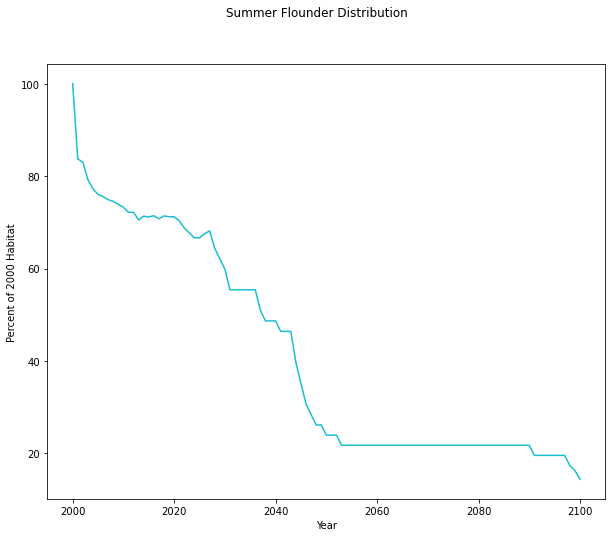

In [21]:
years = np.arange(2000,2101)
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Summer Flounder Distribution')
ax.plot(years, minimum, color='tab:cyan', label='max')
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')

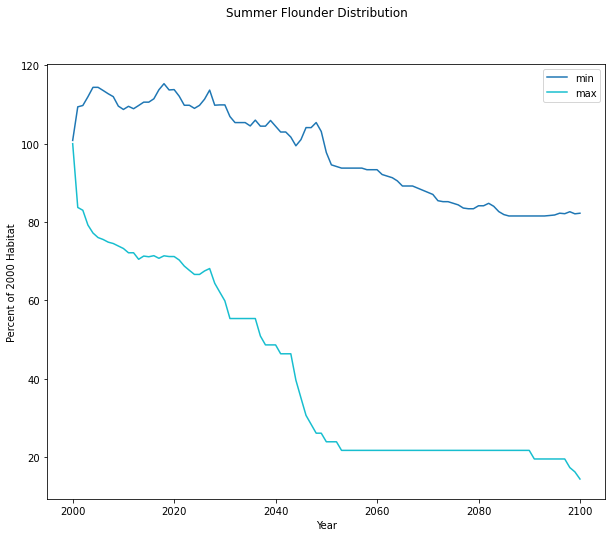

In [17]:
years = np.arange(2000,2101)
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Summer Flounder Distribution')
ax.plot(years, maximum, color='tab:blue', label='min')
ax.plot(years, minimum, color='tab:cyan', label='max')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')

Text(0, 0.5, 'Percent of 2000 Habitat')

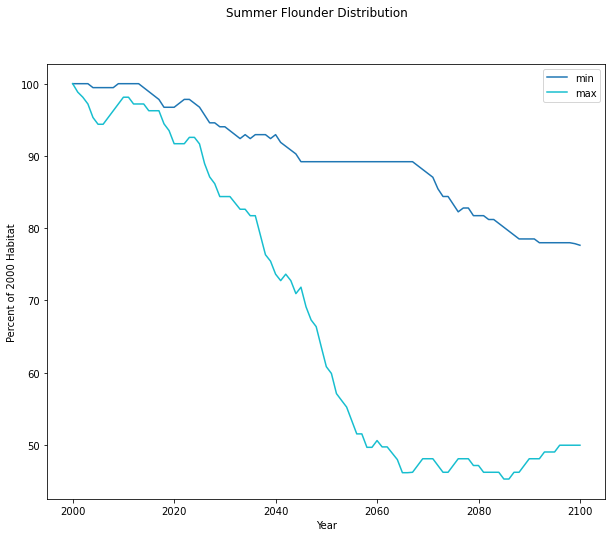

In [20]:
years = np.arange(2000,2101)
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Summer Flounder Distribution')
ax.plot(years, monthMax, color='tab:blue', label='min')
ax.plot(years, monthMin, color='tab:cyan', label='max')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')

In [18]:
crit = [0]*101
month = [0]*101
ens = [0]*101
total = [0]*101
crit_diff = [0]*101
month_diff = [0]*101
ens_diff = [0]*101
for i in range(101):
    crit_diff[i] = (critMax[i]-critMin[i])
    month_diff[i] = (monthMax[i]-monthMin[i])
    ens_diff[i] = (ensMax[i]-ensMin[i])
for i in range(101):
    total[i] = crit_diff[i]+month_diff[i]+ens_diff[i]
for i in range(101):
    crit[i] = (difference[i]*crit_diff[i])/total[i]
    month[i] = (difference[i]*month_diff[i])/total[i]
    ens[i] = (difference[i]*ens_diff[i])/total[i]
added = [0]*101
for i in range(101):
    added[i] = crit[i]+month[i]+ens[i]

In [19]:
crit_line = [0]*101
for i in range(101):
    crit_line[i] = maximum[i]-crit[i]
month_line = [0]*101
for i in range(101):
    month_line[i] = crit_line[i]-month[i]
ens_line = [0]*101
for i in range(101):
    ens_line[i] = month_line[i]-ens[i]

Text(0, 0.5, 'Percent of 2000 Habitat')

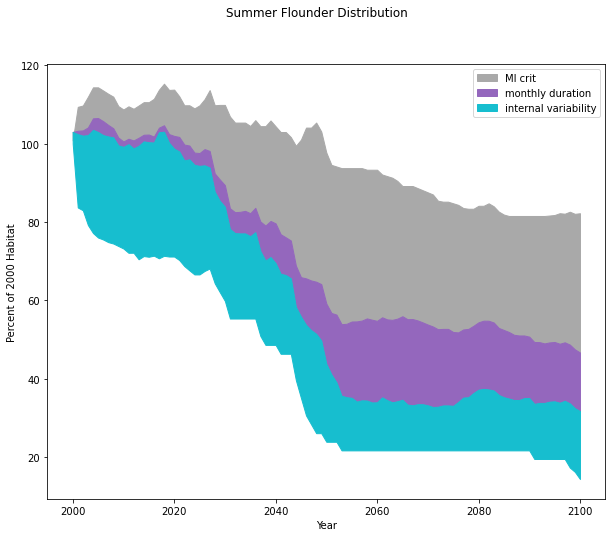

In [20]:
years = np.arange(2000,2101)
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Summer Flounder Distribution')
ax.fill_between(years, maximum, crit_line, color='darkgray', label='MI crit')
ax.fill_between(years, crit_line, month_line, color='tab:purple', label ='monthly duration')
ax.fill_between(years, month_line, ens_line, color='tab:cyan', label='internal variability')

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Percent of 2000 Habitat')